# การสร้างแผนที่ contour จากข้อมูล METAR 
* METeorological Aerodrome Reports (METARs) เป็นข้อมูลที่รายงานสภาพอากาศ มักใช้ในงานอุตุนิยมวิทยาและงานด้านการบิน https://en.wikipedia.org/wiki/METAR METARs จะรายงานด้วยการเข้ารหัสที่เป็นสากลที่รายงานผลการตรวจวัดของแต่ละสถานี  ดังตัวอย่างแผนที่ https://www.aviationweather.gov/metar
* ในแบบฝึกหัดนี้เราจะมาทำการดึงข้อมูล METARs ของแต่ละสถานีทั่วประเทศสหรัฐอเมริกาด้วยการใช้แพคเกจ Siphon https://unidata.github.io/siphon/latest/index.html ที่จะทำการดึงข้อมูลจากเวปเซิร์ฟเวอร์ THREDDS Data Server 4.6 ที่พัฒนาโดย UINIDATA https://www.unidata.ucar.edu/software/tds/current/
* จากนั้นจะทำการประมาณค่าเชิงพื้นที่เพื่อให้ข้อมูลแต่ละสถานีกลายเป็นข้อมูลกริดหรือราสเตอร์ เพื่อทำการสร้างเส้น contour ด้วยการประมาณค่า altimeter เชิงพื้นที่ด้วยวิธีการ cressman interpolation
* ข้อมูล Metar ดาวน์โหลดได้จากลิงก์
    * http://thredds.atmos.albany.edu:8080/thredds/catalog/metar/ncdecodedNAm/catalog.html?dataset=metar/ncdecodedNAm/Metar_NAm_Station_Data_fc.cdmr
    * สามารถ subset ได้โดยทำได้หลายฟอร์แมทจากลิงก์นี้ http://thredds.atmos.albany.edu:8080/thredds/ncss/metar/ncdecodedNAm/Metar_NAm_Station_Data_fc.cdmr/dataset.html
    * ข้อมูล Metar กรณีศึกษา ดาวน์โหลดได้จากที่นี่ https://thredds-dev.unidata.ucar.edu/thredds/catalog/catalog.html
    * https://unidata.github.io/MetPy/latest/examples/plots/Station_Plot.html
    * ข้อมูล Metar แบบ text ฟอร์แมทแบบเรียลไทม์ที่ใช้ในการสร้างแผนที่ในแบบฝึกหัดนี้มาจากลิงก์ https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html
    
* โค้ดนำมาจากยูทูป https://www.youtube.com/watch?v=M-6rLqk_XA8&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=145
* คำสั่งพื้นฐานในการใช้ jupyter
    * shift+enter รันคำสั่ง
    * shift+tab อ่านคำอธิบายฟังก์ชัน
    * กด b เพิ่มกล่องคำสั่งทางด้านล่างของกล่องปัจจุบัน
    * กด a เพิ่มกล่องคำสั่งทางด้านบนของกล่องปัจจุบัน
    * กด d d ลบกล่องคำสั่งปัจจุบัน

* พื้นฐานที่ควรมีก่อนการใช้งาน Metpy ควรมีทักษะดังนี้ตามลำดับการเรียนรู้ครับ
    * ภาษาไพธอน นิสิตสามารถเรียนรู้ด้วยตนเองจาก อ.ประเสริฐครับ ลิงก์นี้ https://www.youtube.com/watch?v=4MbmbzWAMsg&list=PLoTScYm9O0GH4YQs9t4tf2RIYolHt_YwW&index=13
    * แพคเกจ numpy เอาไว้จัดการข้อมูลอาเรย์หลายมิติ ทางด้านเราก็จะเป็นข้อมูลราสเตอร์ เช่น ข้อมูลภาพดาวเทียมที่มีหลายแบนด์ หรือข้อมูล renalysis หรือข้อมูล forecasting นิสิตสามารถเรียนรู้ด้วยตนเองจาก อ.ประเสริฐครับ ลิงก์นี้ https://www.youtube.com/watch?v=ts2L5mtMMi8&list=PLoTScYm9O0GFNEpzsCBEnkUwgAwOu_PWw
    * แพคเกจ matplotlib  เอาไว้พลอตภาพ https://www.youtube.com/watch?v=WOEOH8OV99k&list=PLoTScYm9O0GGRvUsTmO8MQUkIuM1thTCf
    * แพคเกจ pandas เอาไว้จัดการข้อมูล spread sheet เรียนรู้ด้วยตนเองจาก อ.ประเสริฐ จากลิงก์นี้ครับ https://www.youtube.com/watch?v=W661Zy939Q0&list=PLoTScYm9O0GFVfRk_MmZt0vQXNIi36LUz&index=20
    * แพคเกจ xarray เอาไว้เพื่อจัดการข้อมูลอารเย์หลายมิติ ลองเล่นดูครับ https://docs.xarray.dev/en/stable/gallery.html


In [1]:
# นำเข้าโมดูลที่ต้องการใช้
from siphon.catalog import TDSCatalog
# หาก module not found ให้ลง conda install siphon ใน environment ที่ติดตั้ง metpy ไว้

from metpy.io import parse_metar_file

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# ดึงข้อมูล Metar ที่เก็บไว้มาจาก catalog ในรูปแบบ xml เพื่อดึง text ไฟล์ที่เก็บไว้ออกมาจากลิงก์ https://unidata.github.io/MetPy/latest/examples/plots/Station_Plot.html
cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')


In [3]:
# ตรวจสอบว่าในไฟล์ catalog.xml มีข้อมูลของ metar วันเวลาใดบ้าง
cat.datasets

['metar_20220322_0000.txt', 'metar_20220322_0100.txt', 'metar_20220322_0200.txt', 'metar_20220322_0300.txt', 'metar_20220322_0400.txt', 'metar_20220322_0500.txt', 'metar_20220322_0600.txt', 'metar_20220322_0700.txt', 'metar_20220322_0800.txt', 'metar_20220322_0900.txt', 'metar_20220322_1000.txt', 'metar_20220322_1100.txt', 'metar_20220322_1200.txt', 'metar_20220322_1300.txt', 'metar_20220322_1400.txt', 'metar_20220322_1500.txt', 'metar_20220322_1600.txt', 'metar_20220322_1700.txt', 'metar_20220322_1800.txt', 'metar_20220322_1900.txt', 'metar_20220322_2000.txt', 'metar_20220322_2100.txt', 'metar_20220322_2200.txt', 'metar_20220322_2300.txt', 'metar_20220323_0000.txt', 'metar_20220323_0100.txt', 'metar_20220323_0200.txt', 'metar_20220323_0300.txt', 'metar_20220323_0400.txt', 'metar_20220323_0500.txt', 'metar_20220323_0600.txt', 'metar_20220323_0700.txt', 'metar_20220323_0800.txt', 'metar_20220323_0900.txt', 'metar_20220323_1000.txt', 'metar_20220323_1100.txt', 'metar_20220323_1200.txt', 

In [4]:
# get metar of next to the last dataset นั่นคือ ให้ใช้อินเด็กซ์ -2 จะได้ mtar ของชั่วโมงล่าสุด
ds = cat.datasets[-2]

In [5]:
# ตรวจสอบชื่อไฟล์ metar
ds

metar_20220422_0100.txt

In [6]:
# ทำการดาวน์โหลดข้อมูล metar ของชั่วโมงล่าสุด
ds.download() 

In [7]:
# นำเข้าข้อมูล metar เข้าสู่ dataframe ของ pandas
df=parse_metar_file(ds.name)

In [8]:
# อ่านข้อมูลแถวบนสุด 5 แถวของ dataframe
df.head()

# สังเกตุว่ามีข้อมูล latitude และ longitude ของแต่ละสถานี แล้วตัวแปรอื่นๆ ตามมาด้านหลัง ซึ่งสามารถศึกษาได้จากลิงก์นี้ http://thredds.atmos.albany.edu:8080/thredds/catalog/metar/ncdecodedNAm/catalog.html?dataset=metar/ncdecodedNAm/Metar_NAm_Station_Data_fc.cdmr
# หากต้องการสร้าง contour ของค่า altimeter ที่วัดได้แต่ละสถานี ก็จะต้องทำให้ข้อมูลแบบจุด หรือ station นี้ กลายเป็นข้อมูลกริดหรือราสเตอร์ก่อน
# อ่าน altimeter เครื่องวัดระดับความสูงจากระดับน้ำทะเลโดยแปลงมาจากค่าความกดอากาศ https://en.wikipedia.org/wiki/Altimeter

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
K27K,K27K,38.233333,-84.433333,289.0,2022-04-22 00:55:00,0.0,0.0,NaN,16093.44,NaN,...,15.0,13.0,30.36,0,0,0,AO1,1028.38,-0.000000,-0.000000
KTGI,KTGI,37.833333,-76.000000,2.0,2022-04-22 00:55:00,160.0,8.0,NaN,16093.44,NaN,...,15.0,11.0,30.38,0,0,0,AO1 T01480105,1029.09,-2.736161,7.517541
KI43,KI43,38.983333,-82.583333,221.0,2022-04-22 00:55:00,0.0,0.0,NaN,16093.44,NaN,...,15.0,12.0,30.37,0,0,0,AO2,1028.75,-0.000000,-0.000000
KS32,KS32,47.420000,-98.100000,684.0,2022-04-22 00:55:00,100.0,10.0,NaN,16093.44,NaN,...,3.0,1.0,30.20,0,0,0,AO2 TSNO,1026.08,-9.848078,1.736482
K2J9,K2J9,30.600000,-84.550000,69.0,2022-04-22 00:55:00,0.0,0.0,NaN,16093.44,NaN,...,20.0,16.0,30.32,0,0,0,AO2,1026.92,-0.000000,-0.000000


In [9]:
# กำหนดค่าเส้นโครงแผนที่ของประเทศสหรัฐอเมริกา
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35, standard_parallels=(30,60))

#กำหนดค่าเส้นโครงแผนที่ของข้อมูลซึ่งเป็น geographic = PlateCarree
datacrs = ccrs.PlateCarree()

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


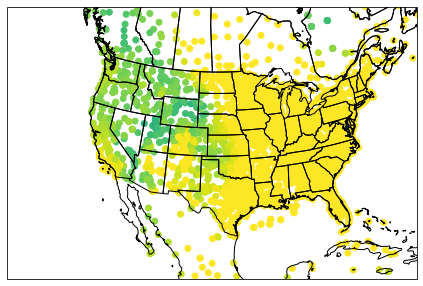

In [10]:
# กำหนดค่าการพลอตแผนที่
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], datacrs)

# เพิ่มตกแต่งแผนที่
ax.add_feature(cfeature.COASTLINE.with_scale('50m')) #https://www.naturalearthdata.com/downloads/ '50m' คือ แผนที่  1:50,000,000
ax.add_feature(cfeature.STATES.with_scale('50m'))

# แสดงแผนที่แบบจุด
ax.scatter(df['longitude'], df['latitude'],c=df['altimeter'], transform=datacrs, vmin=29, vmax=30) 

# สิ่งที่ต้องการ ไม่ใช่แผนที่จุด แต่ต้องการ contour ที่ต้องสร้างกริดก่อนด้วยการประมาณค่าเชิงพื้นที่

In [11]:
df.shape

(7803, 31)

In [12]:
# ทำการกรองข้อมูลด้วยการขจัดแถวที่ไม่มีข้อมูล
df = df.dropna(subset=['latitude', 'longitude','altimeter'])

In [13]:
# ตรวจสอบขนาดข้อมูล
df.shape

(7361, 31)

In [14]:
# ต่อไปจะทำการประมาณค่าเชิงพื้นที่
from metpy.interpolate import interpolate_to_grid, remove_nan_observations

# สร้างตัวแปรเพื่อเก็บค่าพิกัดและค่าที่จะประมาณค่าเชิงพื้นที่
lon = df['longitude'].values
lat = df['latitude'].values

In [15]:
# แปลงค่า lat และ lon เป็นค่า map coordinate เพื่อจะได้ทำการประมาณค่าเชิงพื้นที่ได้
xp, yp, _ = mapcrs.transform_points(datacrs, lon, lat).T

In [16]:
# ตรวจสอบค่าการแปลงระบบพิกัด
xp[:5], yp[:5]

(array([1318656.93903644, 2028179.66904768, 1455542.61031647,
         138511.58668843, 1468736.95544682]),
 array([ 479334.64925735,  613782.11766878,  590681.25597932,
        1340198.94550175, -340528.08877398]))

In [17]:
# ทำการ mask ค่าที่ nan
x_masked, y_masked, alt = remove_nan_observations(xp, yp, df['altimeter'].values)

In [18]:
# ตอนนี้สามารถทำการ interpolate ได้แล้ว
#cressman เป็นวิธีการประมาณค่าที่ใช้กันอย่างแพร่หลายในทางอุตุนิยมวิทยา
#https://unidata.github.io/MetPy/latest/examples/gridding/Inverse_Distance_Verification.html
altgridx, altgridy, alt = interpolate_to_grid(x_masked, y_masked, alt, interp_type='cressman') 


<a list of 538 text.Text objects>

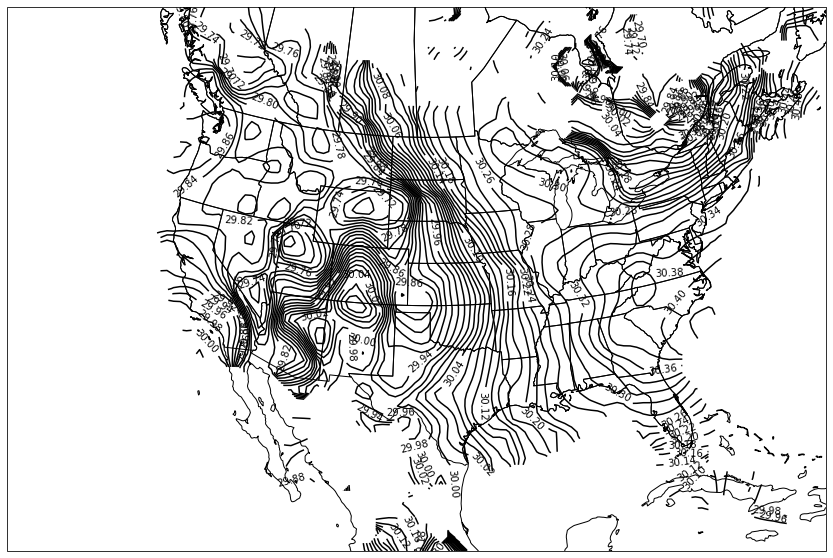

In [19]:
# กำหนดค่าการพลอตแผนที่
import numpy as np
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], datacrs)

# เพิ่มตกแต่งแผนที่
ax.add_feature(cfeature.COASTLINE.with_scale('50m')) #https://www.naturalearthdata.com/downloads/ '50m' คือ แผนที่  1:50,000,000
ax.add_feature(cfeature.STATES.with_scale('50m'))

# แสดงแผนที่แบบจุด
c=ax.contour(altgridx, altgridy, alt,  levels=np.arange(26, 32, 0.02), colors='k')
ax.clabel(c)